In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [175]:
df = pd.read_csv('datasets/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [176]:
df.shape

(100000, 9)

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [178]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [179]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [180]:
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

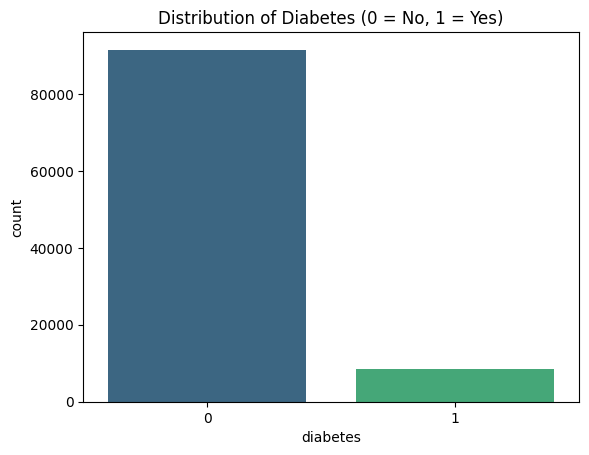

In [181]:
 #Plot the target distribution
sns.countplot(x='diabetes', data=df, hue='diabetes', palette='viridis', legend=False)
plt.title('Distribution of Diabetes (0 = No, 1 = Yes)')
plt.show()

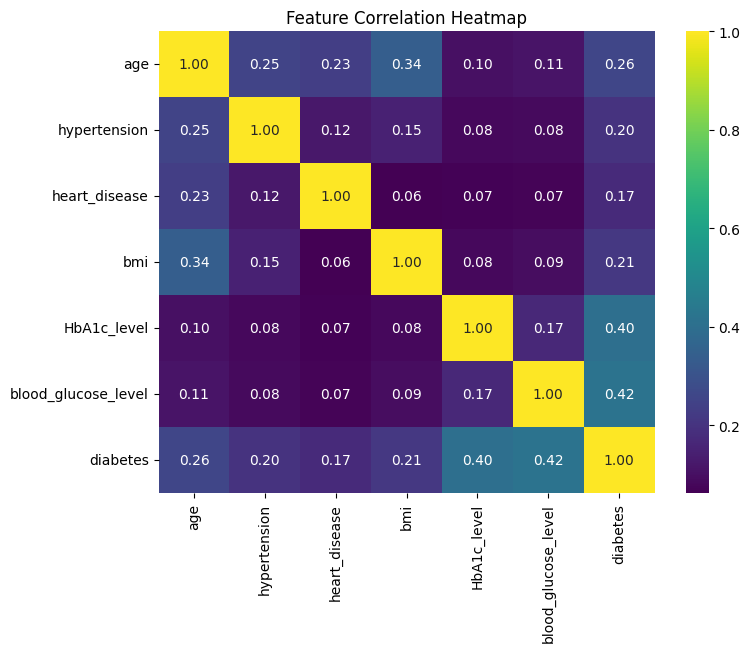

In [182]:
# Select only numeric columns from the DataFrame
numeric_data = df.select_dtypes(include=['number'])

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [183]:
print(f"Duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

Duplicate rows: 3854


In [184]:
df['blood_glucose_level'].replace(0, np.nan, inplace=True)
df['bmi'].replace(0, np.nan, inplace=True)


In [185]:
numeric_cols = df.select_dtypes(include=['number']).columns  
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


print(df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [186]:
X = df.drop(columns=['diabetes'])  
y = df['diabetes']

In [187]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [188]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [195]:
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

# Define preprocessors
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing on X_train before SMOTE
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)  # Transform test data separately

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Train model separately
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
accuracy = classifier.score(X_test_transformed, y_test)
print(f"Model Accuracy: {accuracy:.4f}")

# Make predictions on the transformed test set
y_pred = classifier.predict(X_test_transformed)


Model Accuracy: 0.9659


In [196]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17509
           1       0.90      0.70      0.79      1721

    accuracy                           0.97     19230
   macro avg       0.93      0.85      0.88     19230
weighted avg       0.96      0.97      0.96     19230



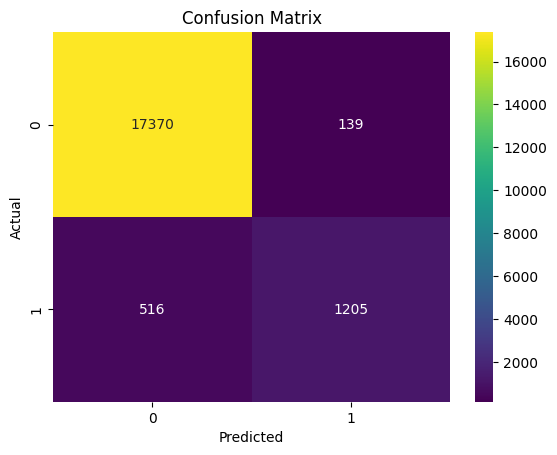

In [197]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [198]:
import joblib

# Save the preprocessing pipeline and trained model
joblib.dump((preprocessor, classifier), "model.pkl")
print("Model saved successfully!")


Model saved successfully!
